# Machine Learning and Neural Computation - Coursework 2: Beat the Bookies!
### <h3><center>By George Hassan-Coring MEng Mathematical Computation SN:15003857</center></h3>

## 1. Introduction

In this coursework, I aim to create my own model using machine learning and statistical techniques that tries to compete with the bookmakers own model of evaluatings odds in the Premier League. As an avid fan and spectator of football, Premier League in particular, I believed that form and confidence of teams is a major factor in a match, almost irregardless of skill. Bearing that in mind, I aimed to create several features that attempt to measure this over a period of games as my main aim. My final results after tweaking the methodology give me an accuracy of around 57% which may be overestimated because of the relative amount of data I have but it still seems to give me a slight edge over the approximate 53% accuracy of bookies.

## 2. Data Import

First, we import the data given for the task and the extra data I downloaded from www.football-stats.co.uk which is this season so fars results and match data which weren't included in the original training data.

In [209]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

"""
Import some libraries that are useful: csv for reading/writing csv files, pandas for reading csv files as dataframes
and ready to be used in the actual supervised learning part and numpy for some manipulation that needs to be done.
 Pyplot is imported for graphing data easily.
"""

#E0 was downloaded from www.football-stats.co.uk and I have edited it to remove the bookies odds that are included in E0edited.csv
#Read E0edited.csv into dataframe
season1718 = pd.read_csv("E0edited.csv")


#Now we import the given data for training which has an almost identical format for the games dating back to 2005
#However it has some extra columns which we will change
fullData = pd.read_csv("epl-training.csv")


#now we want to remove the ID and Date columns from the given data so the two datasets can be joined.
#ID is made redundant by the dataframes indexing and the dates are not comprehensive and are hard to process.
fullData.drop(['ID', 'Date'], axis=1, inplace = True)


#Now we combine the two datasets with the newest season at the bottom so it is chronologically ordered
fullData = fullData.append(season1718, ignore_index = True)


#We now have the full dataset I wish to work with.
print(fullData)

            HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0            Everton      Man United     0     2   A     0     1   A   
1           Man City       West Brom     0     0   D     0     0   D   
2            Arsenal       Newcastle     2     0   H     0     0   D   
3          Newcastle        West Ham     0     0   D     0     0   D   
4            Chelsea         Arsenal     1     0   H     0     0   D   
5            Chelsea       West Brom     4     0   H     2     0   H   
6          Tottenham         Chelsea     0     2   A     0     1   A   
7          Newcastle      Man United     0     2   A     0     0   D   
8         Man United        Man City     1     1   D     1     0   H   
9          Tottenham       Liverpool     0     0   D     0     0   D   
10         Liverpool      Man United     0     0   D     0     0   D   
11           Arsenal         Everton     2     0   H     2     0   H   
12         Newcastle        Man City     1     0   H     1     0

## 3. Data Transformation and Exploration

Now I have dataset to work with in order to select and remove some features that I feel will make a difference. The list of features I wish to add is: home team goals scored in the last five home games (HGSp5), home team goals conceded in the last five games (HGCp5), home team form in last five home games (HFp5) and similarly for the away team(AGSp5, AGCp5 and AFp5). This is in order to attempt to measure both teams form like I set out to do in the introduction.

The columns I wish to remove from this dataset are: 
- The fulltime score: obviously as it directly affects the result and will not be available for predictions.
- The halftime score and result: I think it will be hard to find a relationship between it and results and may cloud the predictions.
- Full time result: This needs to be turned into its own dataframe as this will be the target values of the classifier.
- Fouls and yellow cards: I don't think these stats will have an obvious impact on the overall result like a red card would so I will exclude them but they are further discussed later in this section. 

Correlation between [HF,AF,HY,AY] and Result:
[-0.028297179705745575, 0.010468856291281111, -0.087378656705882393, 0.020196074578511216] 



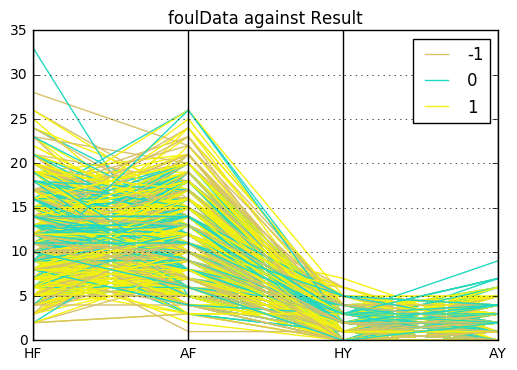

Correlation between [HF,AF,HY,AY] and Result:
[0.21452056821832699, -0.25259835720604618, 0.33882512599858755, -0.30228481609799596] 



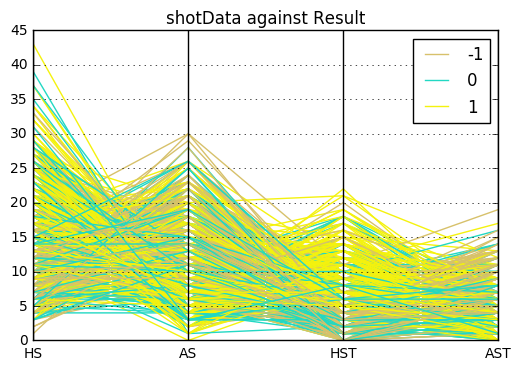

In [210]:
#First I will remove the fulltime and halftime scores and result
#I will not have any of these values for predictions so they should not be trained on
#but I need goal data for a new feature later so this is saved in a separate dataframe
goalData = fullData[['FTHG','FTAG']]
fullData.drop(['FTHG', 'FTAG','HTHG','HTAG','HTR'], axis=1, inplace = True)



#Now I will create a new DataFrame containing the results of each game as a value between 1 and -1: 1 for Home win, 0 for draw and -1 for Away win
#This dataframe is called targetData
targetData = fullData['FTR'].replace({'H':1,'D':0,'A':-1})
#Then drop FTR from the fullData
fullData.drop(['FTR'], axis=1, inplace = True)

#Now I will remove the fouls and yellow card data and save it in its own dataframe foulData
foulData = fullData[['HF','AF','HY','AY']]
#Then drop them from fullData
fullData.drop(['HF','AF','HY','AY'], axis=1, inplace = True)

#To attempt to justify my removal of certain features from the dataset, I will test their correlation with results.
#I will test the correlation between foulData and the results (targetData)
print("Correlation between [HF,AF,HY,AY] and Result:")
print(list(DataFrame.corrwith(foulData, targetData)),'\n')
#As we can see, none of the foul variables seems to have much correlation with the result
#However, this is only a linear correlation test and there may be a non-linear relationship
#So we will discount them for now but see if they make a difference when included in training data

#A visualisation of the foulData
#combine the foul and result data into one dataframe
mergedData1 = pd.concat([foulData,targetData],axis = 1)
parallel_coordinates(mergedData1, 'FTR')
plt.title("foulData against Result")
plt.show()

#As the visualisation shows, not alot can be gained from these variables linearly.

#As a comparison, lets try calculating correlation and visualising home/away shots/on target against result using same method as above
shotData = fullData[['HS','AS','HST','AST']]
print("Correlation between [HF,AF,HY,AY] and Result:")
print(list(DataFrame.corrwith(shotData, targetData)),'\n')
mergedData2 = pd.concat([shotData,targetData],axis=1)
parallel_coordinates(mergedData2, 'FTR')
plt.title("shotData against Result")
plt.show()

Visualising the data helps confirm my previous logic in omitting foul data and including shot data. The value of correlation is pretty much non-existent for the foul data and results and this is shown in the graph which seems unpredictable. There is a stark contrast with the second example. Although a correlation of around 0.2 isn't massive for shots against result, it is much more obvious when using shots on target and this is reflected in the value of correlation and seen in the second graph. These may seem like obvious examples but it helps lend credence to my method of evaluating these features.

This method of visualising was chosen because it is very hard to interpret an n-dimensional scatter when n > 2.

A choice that I didn't discuss so far is the decision to keep referee data in the dataset. My motivation for keeping it was from reading a blogpost (http://discoveringstatistics.blogspot.co.uk/2015/09/the-referees.html) where the author attempts to determine certain referees impact on certain teams because of the classic chants and moans from football fans that certain referees are biased against their team. The final conclusion is that statistically speaking when Mike Dean referees an Arsenal game, their chances of winning decrease. This is a specialised case but the result intrigued me and so I am going to use referees as a feature

My final part of the data transformation is to create the new features I wanted to implement that I mentioned previously.
As a reminder they are: home team goals scored in the last five home games (HGSp5), home team goals conceded in the last five games (HGCp5), home team form in last five home games (HFp5) and similarly for the away team(AGSp5, AGCp5 and AFp5). Then I will test their own relationship to the result and see if they have verified my initial opinions about form.

Correlation between ['HGSp5','HGCp5','HFp5','AGSp5','AGCp5','AFp5'] and Result:
[0.16349828853475121, -0.15568518463435896, 0.19097734606994282, -0.13282336926775581, 0.1035681389567388, -0.14002612808958295] 



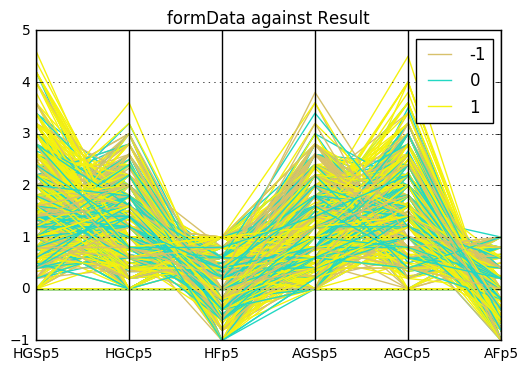

In [211]:
#In order to create these features, I am going to define a function that given a row of the data, it will gather
#the data for the new features and return them as six-tuple
#goalData needs to be included in dataframe when calculating this

def calcForm(data,rownum):
    #returns a 6tuple of hometeams homes goals stats last 5 , aways and each of their form per 5 from set data
    #form is determined as +1 for a win, 0 for a draw and -1 for a loss
    homeTeam  = data['HomeTeam'][rownum]
    awayTeam = data['AwayTeam'][rownum]

    #home stats
    homeStats  = [0,0,0] #goals for, goals against, homeform
    test = 0
    
    #Go through games backwards
    for i in range(rownum-1,0,-1):
        #break if already got last 5 games stats
        if (test == 5):
            break
        #add goals scored and conceded and 
        if (data['HomeTeam'][i] == homeTeam):
            #add goals score/conceded
            homeStats[0] += int(data['FTHG'][i])
            homeStats[1] += int(data['FTAG'][i])
            #+1 if home win or -1 if away win else 0
            if (int(data['FTHG'][i]) > int(data['FTAG'][i])):
                homeStats[2] += 1
            elif(int(data['FTHG'][i]) < int(data['FTAG'][i])):
                homeStats[2] -= 1
            test += 1 #increment for each game inspected
    
    #After consideration I added this line because the stats would be skewed for early games when there is not 5 previous.
    #My first idea was to ignore this at the start and just have form stats as 0
    #but I thought averaging over how many previous games were used would be a fairer method
    if (test != 0):
        homeStats[:] = [x / test for x in homeStats]
    
    
    #repeat for the away team
    awayStats  = [0,0,0] #goals for, goals against, awayform
    test = 0
    for i in range(rownum-1,0,-1):
        if (test == 5):
            break
        if (data['AwayTeam'][i] == awayTeam):
            awayStats[0] += int(data['FTAG'][i])
            awayStats[1] += int(data['FTHG'][i])
            if (int(data['FTHG'][i]) < int(data['FTAG'][i])):
                awayStats[2] += 1
            elif(int(data['FTHG'][i]) > int(data['FTAG'][i])) :
                awayStats[2] -= 1
            test += 1
    
    if (test != 0):
        awayStats[:] = [x / test for x in awayStats]        
            
    #return both sets of stats
    return homeStats + awayStats

#Create dataframe with match info and with goals included again
mergedData3 = pd.concat([fullData,goalData],axis=1)

#Gather the formData from this dataframe
temp =[]
for i in range(0,len(mergedData3)):
    temp.append(calcForm(mergedData3,i))

#create a dataFrame with formData in 
formData = pd.DataFrame(temp,columns=['HGSp5','HGCp5','HFp5','AGSp5','AGCp5','AFp5'])

# I have now created the features I wanted so now I would like to test their statistical significance like I did previously.

print("Correlation between ['HGSp5','HGCp5','HFp5','AGSp5','AGCp5','AFp5'] and Result:")
print(list(DataFrame.corrwith(formData, targetData)),'\n')
mergedData4 = pd.concat([formData,targetData],axis=1)
parallel_coordinates(mergedData4, 'FTR')
plt.title("formData against Result")
plt.show()


From the results here, it is clearly visible that there is correlation between these form stats and the match results however, maybe not as much as I expected previously. If you look at the data, teams that score on average 3.5 to 4.5 over their last 5 home games tend to normally win when next at home and similarly, teams that have conceded alot away over their last 5 games tend to lose the next away game. I believe these results justify my decision to create these features and so I will include them in the training data.

In [212]:
fullData = pd.concat([fullData,formData],axis=1)
#This is now the training data with all features selected.

#One final transformation that needs to be done is to replace any categorical data with dummy variables
#This will allow many classifiers to work on the data
# i.e replace the home and away team features with HomeTeam_Arsenal etc binary values
#This will replace the Home and Away teams and the Referees
#This will vastly increase the number of features but the data will be sparse.

fullData = pd.get_dummies(fullData,columns = ['HomeTeam','AwayTeam','Referee'])

## 4. Methodology Overview

Overall, my main method for producing fixtures for the games given in the assignment is to create a classifier using scikit-learn on the training data that I have added to and manipulated in the previous section. My initial reaction was to use a Random Forest model as it normally achieves a good accuracy from aggregating over the different trees and the only hyperparameter is the maximum number of trees. In order to make comparisons, I will try some different classifiers to observe differences between them and discuss which is the best. To determine the best model, I will use a grid search to find the best hyperparameter values which give the best score when using cross validation. Another interesting comparison would be with bookies own odds as the overall scope of this project was to beat them at their own game!

My original plan was to create a team rating and/or player individual ratings inspired by metrics I had read about like: xG which has recently gained mainstream popularity after being discussed on Match of the Day, GoalImpact which attempts to measure each players direct impact on goals (http://www.goalimpact.com/), ClubElo which applys Elo ranking to football teams in Europe (http://clubelo.com/) or even use ratings from popular video games like FIFA or Football manager; sites like WhoScored, OPTA and the Premier League site itself also have interesting and possibly useful data. Unfortunately, it is hard to use data like player ratings when only current ratings are provided with no historical data available. Another issue is there is alot of money in football betting so companies that have the ability to track the most detailed data are not so keen to share it. (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.7448&rep=rep1&type=pdf) was an interesting research paper but showed its age by using a relatively simple model because so little match data was available in that time, unlike modern football.

Therefore, I decided to add to the data provided with more recent match data and fine tune the features.

## 5. Model	Training/Validation and Results

The first thing to do is create some classifiers. In this section, I will compare results from using Random Forest, K Nearest Neighbours, Ada Boost and Naive Bayes using the best hyperparameters I can find using Scikit-Learn's searching functions.

In [279]:

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

#Set up my first choice of classifier: Random Forest
#Generally, the more estimators the better so I have chosen 500 as this is the best choice for accuracy against performance for me
RandomForestCLF = RandomForestClassifier(n_estimators=500,oob_score = True)
#Because RandomForest is ensemble and randomly samples from the data, cross validation isn't necessary and oob_score provides this functionality
#around 10% (200) of the training set is used as a validation set
RandomForestCLF.fit(fullData[:][-200:],targetData[:][-200:])
print("RandomForest Classifier:")
print("Validation Set Score: ",RandomForestCLF.score(fullData[:][:200],targetData[:200]))
randomForestScore = RandomForestCLF.oob_score_
print("OOB Score: ",randomForestScore,"\n")


#Similarly for Ada boost
#But AdaBoost has no oob_score attribute because it doesn't randomly sample
#So a search is needed, amount of cross validation and range of params is reduced because of AdaBoost's expensive computation
hyperParameters   = {'n_estimators':list(range(50,500,100))}
gSearchAda = GridSearchCV(AdaBoostClassifier(), hyperParameters, cv=10)
gSearchAda.fit(fullData,targetData)
adaparam = gSearchAda.best_params_
print("AdaBoost best hyperparameters: ",adaparam)
adavalue = adaparam['n_estimators']

hyperParameters   = [{'n_neighbors':list(range(10,150,10))}]  
gSearchKNeigh = GridSearchCV(KNeighborsClassifier(), hyperParameters, cv=100)
gSearchKNeigh.fit(fullData,targetData)
kNNparam = gSearchKNeigh.best_params_
print("K Nearest Neighbours best hyperparameters: ",kNNparam)
kNNvalue = kNNparam['n_neighbors']



RandomForest Classifier:
Validation Set Score:  0.565
OOB Score:  0.55 

AdaBoost best hyperparameters:  {'n_estimators': 50}
K Nearest Neighbours best hyperparameters:  {'n_neighbors': 110}


We have now found the best hyperparameters for Ada Boost and K Nearest Neighbours and will compare this against the results on our validation set from the Random Forest classifier. I considered a Naive Bayes classifier but it didn't fit the context of this problem at all because it assumes independence between samples and between features which is definitely not true.

In [412]:
#Now to compare my 3 classifiers
#Set up AdaBoostClassifier with the tuned parameter
AdaBoostCLF = AdaBoostClassifier(n_estimators = adavalue)
#use same training/validation set as used on Random forest
AdaBoostCLF.fit(fullData[:][-200:],targetData[:][-200:])
adaBoostScore = AdaBoostCLF.score(fullData[:][:200],targetData[:200])

#Now the same for K Nearest Neighbours with tuned parameter
KnnCLF = KNeighborsClassifier(n_neighbors = kNNvalue)
KnnCLF.fit(fullData[:][-200:],targetData[:][-200:])
knnScore = KnnCLF.score(fullData[:][:200],targetData[:200])

scoreList = [randomForestScore,AdaBoostScore,KnnScore]

#create a dataframe to compare results in a table
scoreTable = DataFrame(scoreList,['Random Forest','Ada Boost', 'K Nearest'],columns = ['Validation Score'])
print(scoreTable)

               Validation Score
Random Forest             0.550
Ada Boost                 0.325
K Nearest                 0.565


From the scores we can see that Random Forest and K Nearest give pretty good results while AdaBoost lags around 0.2 behind. This may be due to the computational restrictions I had to enforce on the hyper parameter space. The two higher scores are both encouraging but they are both of similiar accuracy making it hard to choose one or the other. Taking inspiration from classifiers like Random Forest which aggregates a vote from weaker learners, I have decided to test if the combination of these two classifiers yields any decent results.

In [413]:
from sklearn.ensemble import VotingClassifier

aggregateCLF = VotingClassifier(estimators = [('rf',RandomForestCLF),('knn',KnnCLF)],voting='soft')
aggregateCLF = aggregateCLF.fit(fullData[:][-200:],targetData[:][-200:])
aggScore = aggregateCLF.score(fullData[:][:200],targetData[:200])

scoreList.append(aggScore)
scoreTable = DataFrame(scoreList,['Random Forest','Ada Boost', 'K Nearest','Aggregate'],columns = ['Validation Score'])
print(scoreTable)

               Validation Score
Random Forest             0.550
Ada Boost                 0.325
K Nearest                 0.565
Aggregate                 0.570


The new combined classifier gives a tiny improvement over the original 2 but it doesn't seem too significant. A final idea for a comparison metric for these classifiers is a comparison against bookies own odds. Odds were not allowed to be used in the training of the models but they can give a good idea of how good my model is.

In [466]:
#Import the bookie data file, some more transformation needs to be done
bookieData = pd.read_csv('bookie-data.csv')

#need to average each bookmakers results for homeWin, draw, awayWin

#average over the 6 bookmaers for the average odds
homeOdds = bookieData[bookieData.columns[::3]].mean(1)
temp = bookieData.drop('B365H',axis = 1)
drawOdds = temp[temp.columns[::3]].mean(1)
temp = temp.drop('B365D',axis = 1)
awayOdds = temp[temp.columns[::3]].mean(1)

#store as bookieData
bookieData = pd.concat([homeOdds,drawOdds,awayOdds],axis = 1)

#now to convert to probability and account for the bookmakers edge
#this lambda function just changes decimal odds to probabilities
bookieProb = bookieData.apply(lambda x: 1/x)
#sum these probabilities to find the bookies edge (when sum > 1)
bookieSum = bookieProb.sum(axis = 1)
#divide the odds by the bookmakers advantage to make it fairer and remove the edge
bookieProb = bookieProb / bookieSum
bookieProb = bookieProb.iloc[:,0:3] # trim down to 3 columns

#Now find the average difference between model probabilities and normalised bookie probs
#given in form - Away win Home win Draw
predProbAgg = aggregateCLF.predict_proba(fullData)

#define function to rearrange the model probs and find average difference to mean
def bookieScore(modelProb,bookie):
    #rearrange classifier probabilities
    temp = []
    for i in modelProb:
        temp.append([i[1],i[2],i[0]])
    swappedProb = DataFrame(np.array(temp))
    #find differences between probs and find overall mean for all outcomes
    bookieScore = swappedProb.subtract(bookie).stack().mean()
    return bookieScore
    

aggBookieScore = bookieScore(predProbAgg,bookieProb)

#Now find difference between bookies and the other test models (RF and KNN)
predProbRF = RandomForestCLF.predict_proba(fullData)
rfBookieScore = bookieScore(predProbRF,bookieProb)

predProbKNN = KnnCLF.predict_proba(fullData)
knnBookieScore = bookieScore(predProbKNN,bookieProb)

predProbAda = AdaBoostCLF.predict_proba(fullData)
adaBookieScore = bookieScore(predProbAda,bookieProb)

bookieScoreList = [rfBookieScore,knnBookieScore,adaBookieScore,aggBookieScore]


#Show results in a table
bookieScoreTable = DataFrame(bookieScoreList,['Random Forest','Ada Boost', 'K Nearest','Aggregate'],columns = ['Bookie Score'])
print(bookieScoreTable)


               Bookie Score
Random Forest      0.013921
Ada Boost          0.013921
K Nearest          0.013921
Aggregate          0.013921


From the table, we can see that all of the models are giving the same degree of deviation from the bookie score so maybe my idea of taking a mean difference was flawed for this data even if the difference is small. Nevertheless, I have chosen to use my aggregated model of combining Random Forest and K Nearest Neighbours for my final prediction as it seems to be the most accurate on the validation set.

## 6.Final Predictions

Now I will train my classifier on the whole training data set and use a formatted version of the test set (so that it matches my own format of training data) to make predictions.

In [455]:
#read the formatted test data 
#the data is formatted to include form and dummy variables.
testData = pd.read_csv('epl-test-formatted.csv')
#read the original test data to get team names for predictions
originalTest = pd.read_csv('epl-test.csv')
aggregateCLF = aggregateCLF.fit(fullData,targetData)
predictions = aggregateCLF.predict(testData)

homeTeams = np.array(originalTest['HomeTeam'])
awayTeams = np.array(originalTest['AwayTeam'])

#print predictions as results
for i in range(len(predictions)):
    if predictions[i] == 1:
        print(homeTeams[i], "  win")
    elif predictions[i] == -1:
        print(awayTeams[i], "  win")
    else:
        print("Draw")
        




Draw
Draw
Everton   win
Leicester   win
Man City   win
Draw
Draw
West Ham   win


So my final predictions are Everton, Leicester, Man City and West Ham to win and the rest of the results to be draws. The win predictions seem quite feasible but the model seems to skew towards predicting home win or draw.